In [15]:
!sudo pip3 install dask distributed matplotlib pandas gcsfs

    100% |████████████████████████████████| 61kB 4.0MB/s ta 0:00:011
    100% |████████████████████████████████| 81kB 8.0MB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 8.1MB/s eta 0:00:01
    100% |████████████████████████████████| 143kB 7.5MB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 12.2MB/s ta 0:00:01
  Running setup.py bdist_wheel for gcsfs ... done
  Stored in directory: /root/.cache/pip/wheels/9f/0f/b9/5bc5222756d121ccace51ab3084a1c733380908a4e2f939038
Successfully built gcsfs
  Found existing installation: pyasn1 0.1.9
    Not uninstalling pyasn1 at /usr/lib/python3/dist-packages, outside environment /usr


In [16]:
from dask.distributed import Client
client = Client()

In [17]:
import matplotlib.pyplot as plt

In [18]:
import dask.dataframe as dd

def readCSV(file, debug=False):
    if debug: print('Reading ' + file)
    return dd.read_csv(file, parse_dates=['CHARTTIME', 'STORETIME'], dtype={'CGID': 'float64',
       'ICUSTAY_ID': 'float64',
       'ERROR': 'float64',
       'RESULTSTATUS': 'object',
       'STOPPED': 'object',
       'VALUE': 'object',
       'WARNING': 'float64'})

In [19]:
#path = './EVENTS_1000000.csv'
path = 'gs://bdcc_up201505836/EVENTS.csv'
df = readCSV(path)

In [20]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,788,36,165660,241249.0,223834,2134-05-12 12:00:00,2134-05-12 13:56:00,17525.0,15,15.00,L/min,0.0,0.0,NaN,NaN
1,789,36,165660,241249.0,223835,2134-05-12 12:00:00,2134-05-12 13:56:00,17525.0,100,100.00,NaN,0.0,0.0,NaN,NaN
2,790,36,165660,241249.0,224328,2134-05-12 12:00:00,2134-05-12 12:18:00,20823.0,.37,0.37,NaN,0.0,0.0,NaN,NaN
3,791,36,165660,241249.0,224329,2134-05-12 12:00:00,2134-05-12 12:19:00,20823.0,6,6.00,min,0.0,0.0,NaN,NaN
4,792,36,165660,241249.0,224330,2134-05-12 12:00:00,2134-05-12 12:19:00,20823.0,2.5,2.50,NaN,0.0,0.0,NaN,NaN


In [21]:
df.compute().describe()

distributed.nanny - WARNING - Worker process 8820 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 8836 exited with status 1
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 8824 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 8830 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 8840 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 8825 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 9086 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 9119 was killed by unknown signal
distributed.nanny - WARNING - Restarting

KilledWorker: ("('pandas_read_text-read-block-from-delayed-4c45196023c0ce01ac0aa086474b8d1d', 229)", <Worker 'tcp://127.0.0.1:35327', memory: 0, processing: 52>)

distributed.nanny - WARNING - Worker process 9166 exited with status 1
distributed.nanny - WARNING - Restarting worker


### Histogram of values per item
- For a given item, i.e., `ITEMID`, get its respective rows
- Plot its items, i.e., `VALUENUM` entries
- A scatter plot was used as it represents more appropriately the data presented

In [21]:
def item_hist(df, item):
    df_item = df[['ITEMID', 'CHARTTIME', 'VALUENUM']].query(f'ITEMID == {item}')
    df_item.compute().plot(x='CHARTTIME', y='VALUENUM', style='.')
    
    fig = plt.gcf()
    fig.set_size_inches(14, 7)
    
    ax = plt.gca()
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'Scatter of values for ITEMID {item}')

distributed.nanny - WARNING - Restarting worker


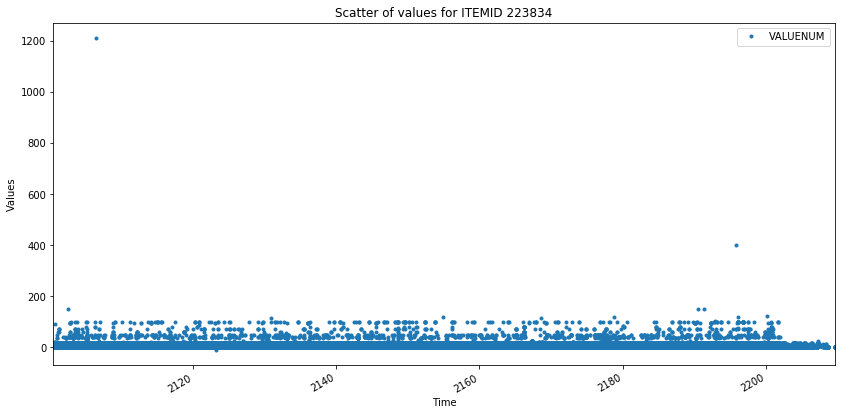

In [22]:
item_hist(df, item=223834)

### Histogram of values per patient

- For each patient, i.e., `SUBJECT_ID`, get its hospital admissions, i.e., `HADM_ID`
- For each hospital admission, plot the entries for each item, i.e., `VALUENUM` for each `ITEMID`
- A scatter plot was used as it represents more appropriately the data presented

In [23]:
# Get histogram of values per patient
def patient_hist(df, patient):
    
    
    df[['SUBJECT_ID', 'ITEMID', 'VALUENUM', 'HADM_ID']]\
                .query(f'SUBJECT_ID == {patient}')\
                .compute()\
                .groupby('HADM_ID')['ITEMID', 'VALUENUM']\
                .plot(x='ITEMID', y='VALUENUM', kind='scatter')
    
    fig = plt.gcf()
    fig.set_size_inches(14, 7)
    
    ax = plt.gca()
    ax.set_xlabel('Items')
    ax.set_ylabel('Values')
    ax.set_title('')

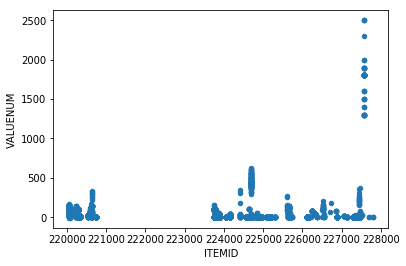

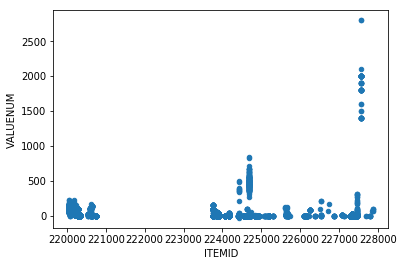

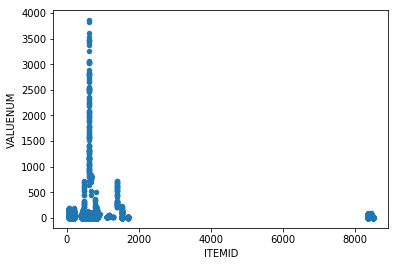

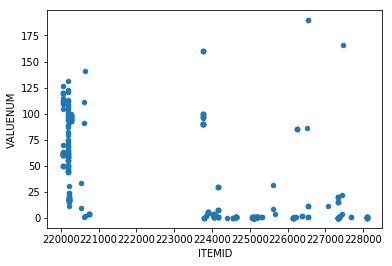

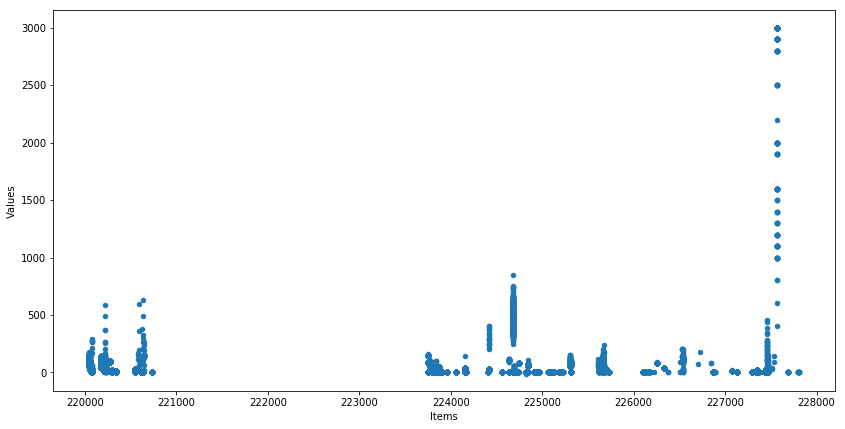

In [24]:
patient_hist(df, patient=2090)

In [25]:
# Get histogram of frequency per item
def item_hist(df):
    df[['ITEMID', 'VALUENUM']]\
                .compute()\
                .groupby('ITEMID').count()\
                .hist()
    
    fig = plt.gcf()
    fig.set_size_inches(14, 7)
    
    ax = plt.gca()
    ax.set_xlabel('Items')
    ax.set_ylabel('Frequency')
    ax.set_title('Frequency per item')

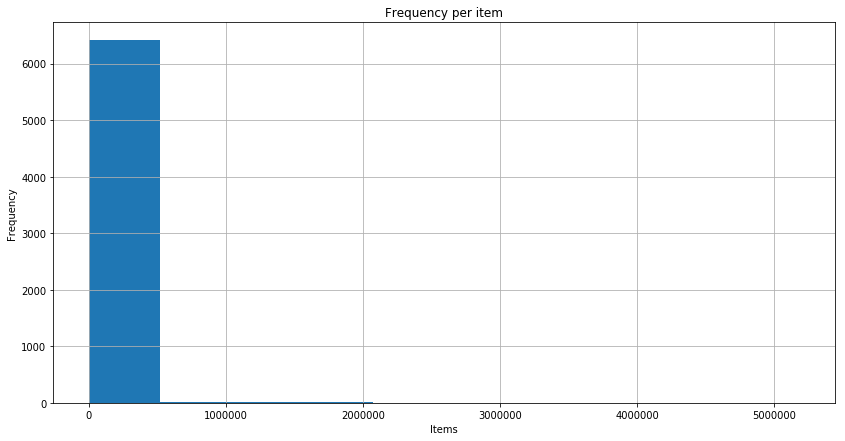

In [26]:
item_hist(df)

### Scatter of items's values over time
- For a given Intensive Care Unit instance, i.e., `ICUSTAY_ID`, get its entries
- Plot its items' values, i.e., `VALUENUM` entries, through time

In [27]:
def icu_hist(df, icu):
    df_icu = df[['SUBJECT_ID', 'VALUENUM', 'ICUSTAY_ID', 'CHARTTIME', 'ITEMID']]\
                .query(f'ICUSTAY_ID == {icu}')\
                .compute()\
                .plot(x='CHARTTIME', y='VALUENUM', style='o')
    
    fig = plt.gcf()
    fig.set_size_inches(14, 7)
    
    ax = plt.gca()
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'Values over time for ICUSTAY {261926}')

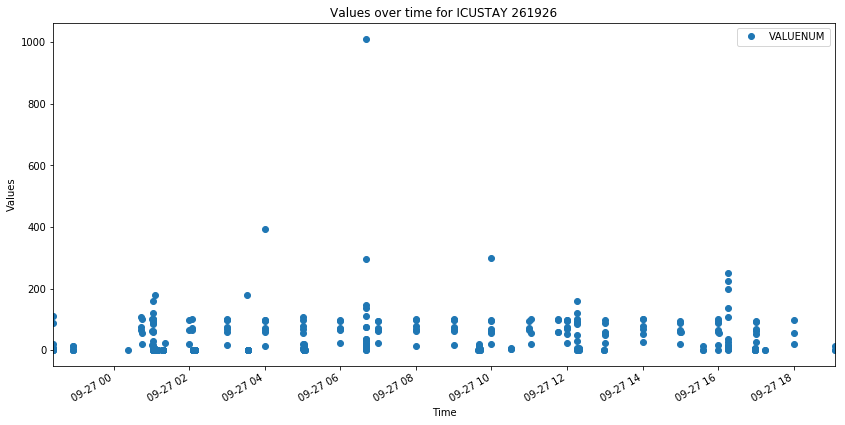

In [28]:
icu_hist(df, 261926)